In [1]:
import logging
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import pykeen
from pykeen.kge_models import ConvE
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [2]:
%matplotlib inline

In [3]:
logging.basicConfig(level=logging.INFO)
logging.getLogger('pykeen').setLevel(logging.INFO)

print(sys.version)

In [4]:
print(time.asctime())

Thu May 30 16:55:00 2019


In [5]:
print(pykeen.get_version())

0.0.26-dev


Check which hyper-parameters are required by ConvE:

In [6]:
ConvE.hyper_params

['embedding_dim',
 'ConvE_input_channels',
 'ConvE_output_channels',
 'ConvE_height',
 'ConvE_width',
 'ConvE_kernel_height',
 'ConvE_kernel_width',
 'conv_e_input_dropout',
 'conv_e_feature_map_dropout',
 'conv_e_output_dropout',
 'margin_loss',
 'learning_rate']

Define output directory:

In [7]:
output_directory = os.path.join(
    os.path.expanduser('~'), 
    'Desktop', 
    'pykeen_test'
)

Define hyper-parameters:

Note: ConvE_height * ConvE_width == embedding_dim

Note: ConvE_kernel_height <= ConvE_height

Note: ConvE_kernel_width <= ConvE_width

Train ConvE:

In [8]:
# For the new model
config = dict(
#     random_seed                 = 22,
    embedding_dim               = 200,
    ConvE_input_channels        = 1,  
    ConvE_output_channels       = 32,  
    ConvE_height                = 10,
    ConvE_width                 = 20,
    ConvE_kernel_height         = 3,
    ConvE_kernel_width          = 3,
    conv_e_input_dropout        = 0.2,
    conv_e_feature_map_dropout  = 0.2,
    conv_e_output_dropout       = 0.3,
    margin_loss                 = 1,
    preferred_device            = 'gpu',
)

In [9]:
model = ConvE(**config)

/home/lauve/.conda/envs/pykeen_horror/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [10]:
# train_triples = model.load_triples_from_path('../../tests/resources/data/rdf.nt')
train_triples, valid_triples, test_triples = model.load_triples_from_path(
    ['fb15k237_train.tsv', 'fb15k237_valid.tsv', 'fb15k237_test.tsv'])

In [11]:
# from pykeen.kge_models.base import load_data
# triples = load_data('fb15k_train.tsv')
# triples_short = triples[:10000]
# train_triples = test_triples = model.load_triples(triples_short)

In [12]:
model.train()

ConvE(
  (criterion): MarginRankingLoss()
  (inp_drop): Dropout(p=0.2)
  (hidden_drop): Dropout(p=0.3)
  (feature_map_drop): Dropout2d(p=0.2)
  (loss): BCELoss()
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=10368, out_features=200, bias=True)
)

In [13]:
# Load labels
# import pickle
# labels = pickle.load(open('Triple_full_labels.pkl', 'rb'))

In [14]:
losses = model.fit(train_triples, learning_rate=0.001, num_epochs=10, batch_size=128, create_inverse_triples=True, label_smoothing=0.1)

INFO:pykeen.kge_models.base:Creating inverse triples
INFO:pykeen.kge_models.base:Created inverse triples. It took 0.11 seconds
INFO:pykeen.kge_models.base:Creating labels for training
100%|██████████| 544230/544230 [00:00<00:00, 600175.65it/s]
INFO:pykeen.kge_models.base:Created labels for training
INFO:pykeen.kge_models.base:****Run Model On CUDA****
Training epoch: 100%|██████████| 10/10 [02:55<00:00, 17.40s/it, loss=0.00102, previous_loss=0.00107]
INFO:pykeen.kge_models.base:Training took 175 seconds 



Visualize loss values:

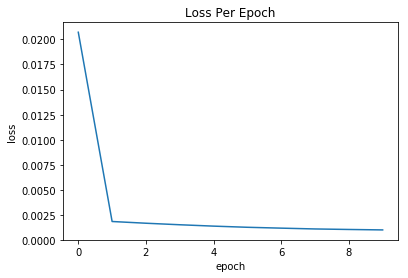

In [15]:
epochs = np.arange(len(losses))
plt.title(r'Loss Per Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epochs, losses)
plt.show()

Move model to cpu

In [16]:
model.eval()

ConvE(
  (criterion): MarginRankingLoss()
  (inp_drop): Dropout(p=0.2)
  (hidden_drop): Dropout(p=0.3)
  (feature_map_drop): Dropout2d(p=0.2)
  (loss): BCELoss()
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=10368, out_features=200, bias=True)
  (entity_embeddings): Embedding(14541, 200)
  (relation_embeddings): Embedding(474, 200)
)

Load test triples

In [17]:
# test_triples = model.map_triples_from_path('../../tests/resources/data/rdf.nt')
# train_triples = model.map_triples_from_path('fb15k237_train.tsv')
# test_triples = model.map_triples_from_path('fb15k237_test.tsv')

Calculate results

In [18]:
from pykeen.utilities.evaluation_utils.metrics_computations import compute_metric_results

In [19]:
results = compute_metric_results(kg_embedding_model=model, mapped_train_triples=train_triples, 
                                mapped_test_triples=test_triples, device = model.device, filter_neg_triples=True)
# results = compute_metric_results(kg_embedding_model=model, mapped_train_triples=test_triples, 
#                                 mapped_test_triples=test_triples[:10000], device = model.device, filter_neg_triples=False)

⚽️ corrupting triples: 100%|██████████| 20466/20466 [00:50<00:00, 402.74it/s]
INFO:pykeen.utilities.evaluation_utils.metrics_computations:Evaluation took 51.07 seconds


In [20]:
results

MetricResults(mean_rank=352.68127626307046, mean_reciprocal_rank=0.2515472373629505, hits_at_k={1: 0.18794586142871103, 3: 0.26864067233460376, 5: 0.3112723541483436, 10: 0.3761115997263755})

## Make subject and object predictions (Is not adjusted to the new code yet)

In [29]:
train_triples[5]

array([   0,  131, 4280])

In [32]:
model.entity_label_to_id['/m/010016']

0

In [33]:
model.relation_label_to_id['/location/location/time_zones']

131

In [34]:
model.entity_label_to_id['/m/02fqwt']

4280

In [35]:
sub = '/m/010016'
rel = '/location/location/time_zones'
obj = '/m/02fqwt'

In [36]:
model.predict_objects(sub,rel)[:10]

array([['/m/02hcv8', '0.040503122'],
       ['/m/02lcqs', '1.2070307e-06'],
       ['/m/02fqwt', '2.4063812e-08'],
       ['/m/03bdv', '7.6117e-10'],
       ['/m/02hczc', '2.7981777e-12'],
       ['/m/02llzg', '9.157466e-14'],
       ['/m/05zppz', '7.651443e-20'],
       ['/m/042g7t', '1.1811104e-21'],
       ['/m/02zsn', '3.4493906e-22'],
       ['/m/04ztj', '5.733041e-23']], dtype='<U32')

In [39]:
model.predict_subjects(obj, rel)[:10]

array([['/m/0f2rq', '0.9985056'],
       ['/m/050l8', '0.9211153'],
       ['/m/0f04v', '0.9084762'],
       ['/m/0vzm', '0.8009412'],
       ['/m/03s5t', '0.5991763'],
       ['/m/081mh', '0.34337118'],
       ['/m/0d9jr', '0.3328025'],
       ['/m/013yq', '0.32480478'],
       ['/m/05fhy', '0.19039018'],
       ['/m/02cl1', '0.15992706']], dtype='<U32')